<a href="https://colab.research.google.com/github/VSUrhuel/vsu-stress-predictor/blob/master/stress_predictor_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
%%capture
!pip install -U scikit-learn
!pip install -U ppscore
!pip install -q ptitprince

In [69]:
# ******************* Data manipulation *******************
import pandas as pd
import numpy as np

# ******************* Google Drive *******************
from google.colab import drive

# ******************* Tenserflow *************************
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input
from keras.callbacks import ModelCheckpoint, EarlyStopping

# ******************* Data preprocessing ********************
from sklearn.model_selection import train_test_split, StratifiedKFold

# ******************* Metric ***********************
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix

import matplotlib.pyplot as plt

In [70]:
drive.mount('/content/drive')
%cd /content/drive/My Drive/kaggle/input

data = pd.read_csv('student_lifestyle_dataset.csv')
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/kaggle/input


,Student_ID,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
0,1,6.9,3.8,8.7,2.8,1.8,2.99,Moderate
1,2,5.3,3.5,8.0,4.2,3.0,2.75,Low
2,3,5.1,3.9,9.2,1.2,4.6,2.67,Low
3,4,6.5,2.1,7.2,1.7,6.5,2.88,Moderate
4,5,8.1,0.6,6.5,2.2,6.6,3.51,High


In [71]:
def map_stress_level(level):
    if level == 'Low':
        return 0
    elif level == 'Moderate':
        return 1
    elif level == 'High':
        return 2

In [86]:
X = pd.get_dummies(data.drop(['Student_ID', 'Stress_Level'], axis=1))
y = data['Stress_Level'].apply(map_stress_level)

In [87]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=.5)

In [88]:
model = Sequential()
model.add(Input(shape=(len(X_train.columns),)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=3, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [89]:
checkpoint = ModelCheckpoint(
    filepath='/content/drive/My Drive/Colab Notebooks/bestModel.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,  # Stop if no improvement after 10 epochs
    verbose=1
)

In [90]:
learn = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),  # Provide validation data
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint]
)
print("Best validation loss:", min(learn.history['val_loss']))

Epoch 1/100
45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4893 - loss: 1.0540   
Epoch 1: val_loss improved from inf to 0.72829, saving model to /content/drive/My Drive/Colab Notebooks/bestModel.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4980 - loss: 1.0372 - val_accuracy: 0.7400 - val_loss: 0.7283
Epoch 2/100
40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7184 - loss: 0.6878   
Epoch 2: val_loss improved from 0.72829 to 0.58497, saving model to /content/drive/My Drive/Colab Notebooks/bestModel.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7175 - loss: 0.6832 - val_accuracy: 0.7600 - val_loss: 0.5850
Epoch 3/100
43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7701 - loss: 0.5639 
Epoch 3: val_loss improved from 0.58497 to 0.56283, saving model to /content/drive/My Drive/Colab Notebooks/bestModel.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7710 - loss: 0.5611 - val_accuracy: 0.7800 - val_loss: 0.5628
Epoch 4/100
31/50 ━━━━━━━

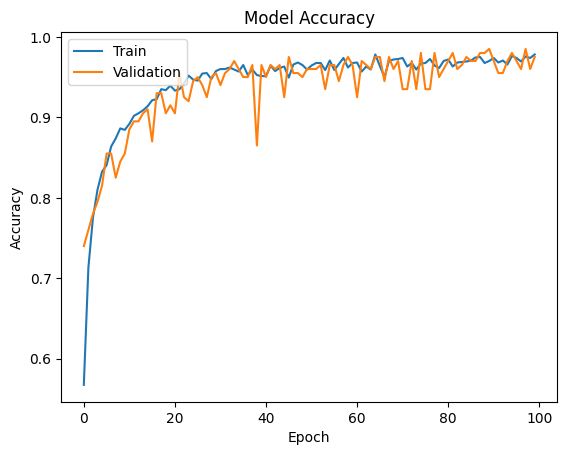

In [99]:
plt.plot(learn.history['accuracy'])
plt.plot(learn.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
epoch_count = len(learn.history['accuracy'])  # Total epochs
plt.savefig(f'/content/drive/My Drive/Colab Notebooks/accuracy_epoch{epoch_count}.png')

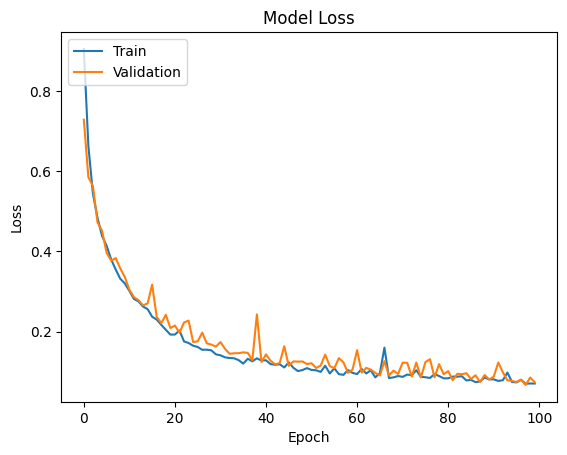

In [100]:
# Plot training & validation loss values
plt.plot(learn.history['loss'])
plt.plot(learn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

epoch_count = len(learn.history['loss'])  # Total epochs
plt.savefig(f'/content/drive/My Drive/Colab Notebooks/loss_epoch{epoch_count}.png')
plt.show()

In [93]:
y_hat = model.predict(X_test)
y_hat_classes = np.argmax(y_hat, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [94]:
accuracy = accuracy_score(y_test, y_hat_classes)
cm = confusion_matrix(y_test, y_hat_classes)
print("Accuracy: ", accuracy)

Accuracy:  0.995


Confusion Matrix:



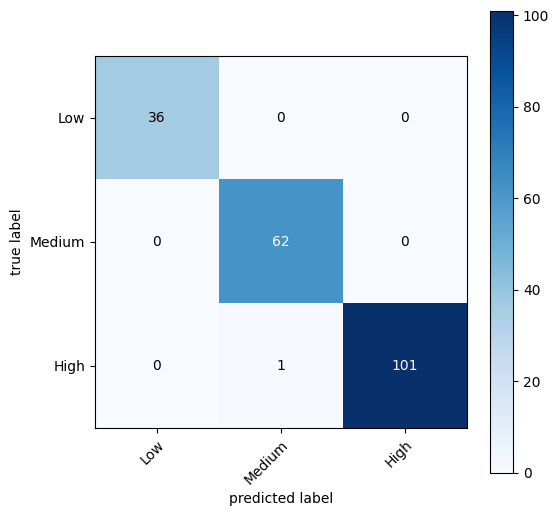

In [95]:
print("Confusion Matrix:\n")
figure, ax = plot_confusion_matrix(conf_mat=cm,
                                   class_names=['Low', 'Medium', 'High'],
                                   figsize=(6,6),
                                   colorbar=True)

In [97]:
model.save('stress-predictor-model-epoch-100.keras')
model.save('/content/drive/My Drive/Colab Notebooks/stress-predictor-model-epoch-100.keras')